In [1]:
import polars as pl
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from annoy import AnnoyIndex
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
tqdm.pandas()
import gc
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, use_memory_fs=False)
#Config
GENERATE_FOR = "kaggle"
TRAIN = True # set True if you want to train the w2vec model from scratch
VECTOR_SIZE = 32
CANDIDATES = 100
DISK_PIECES = 4
VER = 6

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/tmp/ipykernel_256978/4026865164.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
if GENERATE_FOR == "local":
    train_df = pl.concat([pl.read_parquet("./splitted_raw_data/train.parquet"),pl.read_parquet("./splitted_raw_data/val.parquet")])
if GENERATE_FOR == "kaggle":
    train_df = pl.concat([pl.read_parquet('./splitted_raw_data/all_train.parquet'),pl.read_parquet("./splitted_raw_data/test.parquet")])

In [2]:
train_df.shape

(223644219, 4)

Let us now transform the data into a format that the `gensim` library can work with. Thanks to `polars` we can do so very efficiently and very quickly.

There are various ways we could feed our data to our model, however doing so straight from RAM in the form of Python lists is probably one of the fastest! As we have enough resources on Kaggle to do so, let us take this approach!

In [3]:
#word2vec train eden yer burası
if TRAIN:
    sentences_df = train_df.groupby('session').agg(pl.col('aid').alias('sentence'))
    sentences = sentences_df['sentence'].to_list()
    del sentences_df; gc.collect()
    print('Word2Vec training started...')
    w2vec = Word2Vec(sentences=sentences, vector_size=VECTOR_SIZE, min_count=1,window=20, workers=-1) # workers: kaggle nb'de çalıştırcaksan workers ayarla
    print('Word2Vec training, done.')
    wv = w2vec.wv
    wv.save(f"./models/word2vec_{GENERATE_FOR}.wordvectors")

Word2Vec training started...
Word2Vec training, done.


In [4]:
aids = train_df.select(pl.col('aid').unique())['aid'].to_list()
len(aids)

1855603

In [5]:
if TRAIN == False:
    wv = KeyedVectors.load(f"./models/word2vec_{GENERATE_FOR}.wordvectors", mmap='r')

In [6]:
#vektör çıkarma
from tqdm import tqdm
vectors = []
for aid in tqdm(aids):
    vectors.append(wv[aid].tolist())

100%|█████████████████████████████| 1855603/1855603 [00:04<00:00, 382620.38it/s]


In [7]:
aid_vectors = pd.concat([pd.Series(aids,name='aid'),pd.Series(vectors,name='vectors')],axis=1)
aid_vectors.to_parquet(f'./all_features/{GENERATE_FOR}_w2v_aid_vectors.pqt')
del aid_vectors,vectors;gc.collect()

0

### Approximate NN for Similarity Score

In [8]:
#annoy indexleme ve build
from annoy import AnnoyIndex

aid2idx = {aid: i for i, aid in enumerate(wv.index_to_key)}
annoy = AnnoyIndex(VECTOR_SIZE, 'euclidean')

for aid, idx in aid2idx.items():
    annoy.add_item(idx, wv.vectors[idx])
    
annoy.build(20)

True

In [9]:
aid_vectors = pd.read_parquet(f'./all_features/{GENERATE_FOR}_w2v_aid_vectors.pqt')

In [10]:
aid_vectors

,aid,vectors
0,0,"[-0.009594175964593887, -0.0046624355018138885..."
1,1,"[0.009859923273324966, 0.01693369820713997, -0..."
2,2,"[0.024817336350679398, 0.0001684240996837616, ..."
3,3,"[-0.014050107449293137, -0.02541998401284218, ..."
4,4,"[0.030481863766908646, 0.02337062731385231, -0..."
...,...,...
1855598,1855598,"[0.0006951577961444855, -0.02836809679865837, ..."
1855599,1855599,"[-0.02160932496190071, 0.012220602482557297, 0..."
1855600,1855600,"[0.004274539649486542, 0.02614506706595421, -0..."
1855601,1855601,"[0.020589202642440796, 0.01697468012571335, -0..."


In [11]:
def annoy_get_distance(aid1,aid2,aid2idx,annoy):
    return annoy.get_distance(aid2idx[aid1], aid2idx[aid2])

In [21]:
from pathlib import Path
data_dir = Path(f"../raw_data/{GENERATE_FOR}_covisitation") #covisitation path'i
for type_str in tqdm(['clicks','carts','buy2buy']): # typelar
    part = 0
    whole_out_df = []
    for pqt_file in tqdm(sorted(data_dir.glob(f'{GENERATE_FOR}_top_{CANDIDATES}_{type_str}*'))): #ilgili type'a ait filelar
        print(pqt_file)
        temp_df = pd.read_parquet(pqt_file)
        display(temp_df)
        print(k)
        similarities = []
        temp_df['similarity'] = temp_df.parallel_apply(lambda x: annoy_get_distance(x['aid_x'],x['aid_y'],aid2idx,annoy),axis=1)
        whole_out_df.append(temp_df)
        part += 1
        del temp_df; gc.collect()
    whole_out_df = pd.concat(whole_out_df, ignore_index=True)
    whole_out_df.to_parquet(f'./all_features/{GENERATE_FOR}_top_{CANDIDATES}_{type_str}_w2v_similarities.pqt')

  0%|                                                     | 0/4 [00:00<?, ?it/s]

../raw_data/kaggle_covisitation/kaggle_top_100_clicks_v6_0.pqt


,aid_x,aid_y,wgt
0,0,532042,21.146194
1,0,643097,17.376019
2,0,1735605,11.612320
3,0,1848174,11.013269
4,0,706401,9.668176
...,...,...,...
104361006,464999,1341546,1.836428
104361007,464999,1402087,1.836428
104361008,464999,1714562,1.836428
104361009,464999,1783302,1.836428


  0%|                                                     | 0/3 [00:01<?, ?it/s]


NameError: name 'k' is not defined

In [13]:
whole_out_df

,aid_x,aid_y,wgt,similarity
0,1,279811,1.0,0.145617
1,1,850666,1.0,0.129335
2,1,886584,1.0,0.162573
3,1,1533875,1.0,0.149362
4,1,1708199,1.0,0.132836
...,...,...,...,...
39858020,1855601,1636201,1.0,0.146724
39858021,1855601,1758603,1.0,0.158609
39858022,1855601,1783314,1.0,0.125374
39858023,1855601,1791916,1.0,0.137869


<AxesSubplot: >

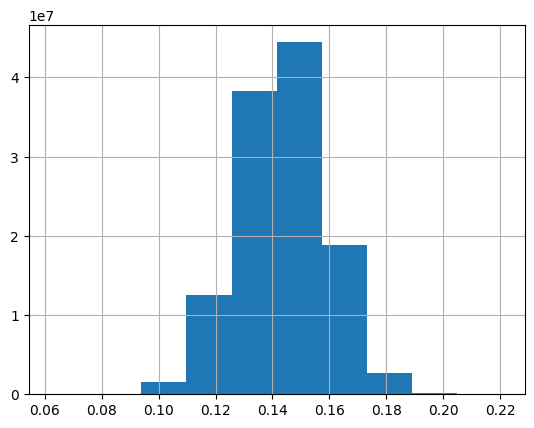

In [22]:
pd.read_parquet(f'./all_features/kaggle_top_{CANDIDATES}_{type_str}_w2v_similarities.pqt').similarity.hist()

<AxesSubplot: >

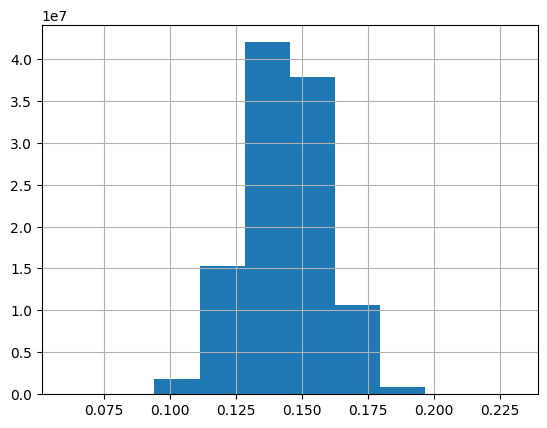

In [23]:
pd.read_parquet(f'./all_features/local_top_{CANDIDATES}_{type_str}_w2v_similarities.pqt').similarity.hist()

In [24]:
!pip list

Package                  Version
------------------------ -----------
aiohttp                  3.8.3
aiosignal                1.3.1
alembic                  1.8.1
annoy                    1.17.1
anyio                    3.6.2
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
asttokens                2.1.0
async-timeout            4.0.2
attrs                    22.1.0
autopage                 0.5.1
backcall                 0.2.0
beautifulsoup4           4.11.1
bleach                   5.0.1
brotlipy                 0.7.0
cachetools               5.2.0
catboost                 1.1.1
certifi                  2022.9.24
cffi                     1.15.1
charset-normalizer       2.0.4
click                    8.1.3
cliff                    4.1.0
cloudpickle              2.2.0
cmaes                    0.9.0
cmd2                     2.4.2
colorlog                 6.7.0
contourpy                1.0.6
convertdate              2.4.0
cryptography             38.0.1
cubinlinker-cu11    